In [5]:
%load_ext autoreload
%autoreload 2
import sys
import time
sys.path.append('../..')

import kradagrad as kg
import kradagrad.riccati as ricc
import numpy as np
import torch
mf = kg.positive_matrix_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ll = np.array([[3,1],[1,5]])
rr = np.array([[11,3],[3,7]])
b = np.arange(8).reshape([2,4]).T
#b = np.arange(4)[:, None]



rr2 = mf.matrix_power_svd(torch.Tensor(rr), 1/2)
ll2 = mf.matrix_power_svd(torch.Tensor(ll), 1/2)

kk = ricc.Kron([ll2, rr2])

dd = ricc.KronDiag([ll2.diag(), rr2.diag()])

rr2 = rr2.numpy()
ll2 = ll2.numpy()

"""
print(kk @ torch.Tensor(b))
print(np.kron(ll2, rr2) @ b)

print((torch.Tensor(b).T @ kk).T)

print(dd @ torch.Tensor(b))
print(np.kron(np.diag(ll2), np.diag(rr2))[:, None] * b)
print(type(b))
"""

L, V = kk.eigh()


"""
print((V @ L @ V.T)._mats, kk._mats)


print((torch.Tensor(b).T @ L).T, L @ torch.Tensor(b))
"""
#L @ np.eye(4)

L.as_vec()[:,None] * torch.Tensor(b)
print()

In [2]:
torch.manual_seed(95054)

a = torch.randn(24, 24).tril()
a = a @ a.T
b = torch.randn(24, 24).tril()
b = b @ b.T

C = torch.randn(576, 1)
C = C / torch.sqrt((C ** 2).sum())

A = ricc.Kron([a, b])
k = 5

In [3]:
import pymanopt
"""
manifold = ricc.RiccatiManifold(A,k)
class EuclideanCache:
    def __init__(self):
        self.Y = None
        self.Ge = None
        self.Gr = None

    def _cache(self, Y, mani):
        mani._preprocess(Y)
        if self.Y is None or not torch.allclose(self.Y, Y):
            self.Y = Y
            self.AY = A @ Y
            self.YtAY = Y.T @ self.AY
            self.CtY = C.T @ Y
            self.YtAsqY = Y.T @ mani._AsqY
            self.Ge = None
            self.Gr = None

    def _save_G(self, Ge, Gr):
        self.Ge = Ge
        self.Gr = Gr

ec = EuclideanCache()


@torch.no_grad()
def make_SY(Y, C, ec, manifold):
    return ec.AY @ manifold._YtY + Y @ (ec.YtAY + manifold._YtYsq) - C @ ec.CtY

@torch.no_grad()
def euc_grad_pt2(Y, SY):
    ASY = A @ SY
    SAY = ec.AY @ ec.YtAY + Y @ (ec.YtAsqY + manifold._YtY @ ec.YtAY) - C @ (C.T @ ec.AY)
    SY3 = SY @ manifold._YtY
    YYtSY = Y @ (Y.T @ SY)
    Ge = ASY + SAY + SY3 + YYtSY
    Gr = manifold.euclidean_to_riemannian_gradient(Y, Ge)
    ec._save_G(Ge, Gr)
    return Ge, Gr

@pymanopt.function.numpy(manifold)
def euc_grad(Y):
    with torch.no_grad():
        Y = torch.Tensor(Y)
        ec._cache(Y, manifold)
        SY = make_SY(Y, C, ec, manifold)
        Ge, Gr = euc_grad_pt2(Y, SY)  # caches them too
    return Gr

@pymanopt.function.numpy(manifold)
def euc_hess(Y, Eta):
    with torch.no_grad():
        Y = torch.Tensor(Y)
        Eta = torch.Tensor(Eta)
        ec._cache(Y, manifold)
        AEta = A @ Eta
        YtEta = Y.T @ Eta
        CtEta = C.T @ Eta
        EtatAY = Eta.T @ ec.AY
        EtatY = YtEta.T

        SY = make_SY(Y, C, ec, manifold)

        SEta = ec.AY @ YtEta + Y @ (Y.T @ AEta + manifold._YtY @ YtEta) - C @ CtEta
        SdotY = ec.AY @ EtatY + AEta @ manifold._YtY + Eta @ (ec.YtAY + manifold._YtYsq) \
            + Y @ (EtatAY + EtatY @ manifold._YtY + ricc._symm2(manifold._YtY @ EtatY))
        SAEta = ec.AY @ (Y.T @ AEta) + Y @ (ec.AY.T @ AEta + manifold._YtY @ Y.T @ AEta) - C @ (C.T @ AEta)

        SdotAY = ec.AY @ (Eta.T @ ec.AY) + AEta @ ec.YtAY + Eta @ (ec.YtAsqY + manifold._YtY @ ec.YtAY) \
            + Y @ (Eta.T @ manifold._AsqY + ricc._symm2(EtatY) @ ec.YtAY + manifold._YtY @ EtatAY)

        PdotY = A @ SdotY + SdotAY + (SdotY + SEta) @ manifold._YtY + SY @ EtatY + Y @ ((SdotY.T + SEta.T) @ Y) + Eta @ (SY.T @ Y)

        PEta = A @ SEta + SAEta + SY @ YtEta + Y @ (Y.T @ SEta)
        He = PdotY + PEta
        if ec.Ge is None or ec.Gr is None:
            Ge, Gr = euc_grad_pt2(Y, SY)
        else:
            Ge, Gr = ec.Ge, ec.Gr
        Hr = manifold.euclidean_to_riemannian_hessian(Y, Ge, He, Eta)
    return Hr

@pymanopt.function.numpy(manifold)
def cost(Y):
    with torch.no_grad():
        Y = torch.Tensor(Y)
        manifold._preprocess(Y)
        L = torch.cat([C, A @ Y, Y], -1)
        _, Lr = torch.linalg.qr(L, 'reduced')
        s = C.size()[-1]
        Lc = Lr[:, :s]
        L2 = Lr[:, s:s+k]
        Ly = Lr[:, s+k:]
    return ((-Lc @ Lc.T + ricc._symm2(L2 @ Ly.T) + Ly @ manifold._YtY @ Ly.T) ** 2).sum() / 4
problem = pymanopt.Problem(manifold, cost, euclidean_gradient=euc_grad, euclidean_hessian=euc_hess)
truster = pymanopt.optimizers.trust_regions.TrustRegions()
opt_result = truster.run(problem)

# real slow...
"""
print()

# homemade low-rank kronecker lyap solver

In [99]:

torch.manual_seed(95054)
st = time.time()
Z = ricc.kron_lyap_greedy(A, C, rank=10, max_it=4)
print(time.time()-st)

def cost_lya(Z):
    AZ = A @ Z
    L = torch.cat([C, AZ, Z], -1)
    _, Lr = torch.linalg.qr(L)
    Lc, LAz, Lz = torch.split(Lr, [C.shape[-1], Z.shape[-1], Z.shape[-1]], dim=-1)
    mat = -Lc @ Lc.T + ricc._symm2(LAz @ Lz.T)
    return (mat ** 2).sum()

def cost_lya_induced(Z):
    CtZ = (C.T @ Z)
    return (Z * (A @ Z @ (Z.T @ Z))).sum() - CtZ @ CtZ.T

print(torch.sqrt(cost_lya(Z)), cost_lya_induced(Z))

0.0403289794921875
tensor(0.4498) tensor([[-0.9292]])


# homemade low-rank kronecker+low-rank lyap solver

In [104]:
S, U = A.eigh()

/localhome/jonathan.mei/miniconda/envs/krad/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/localhome/jonathan.mei/miniconda/envs/krad/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


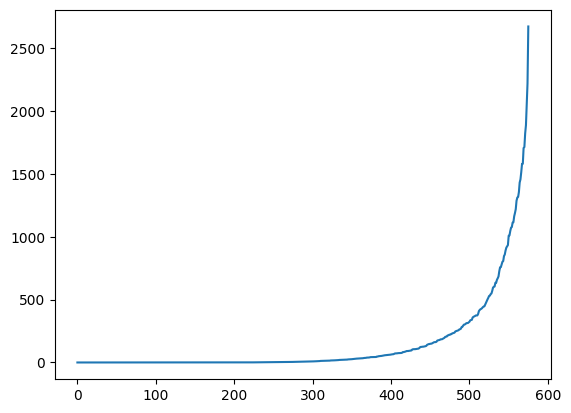

In [108]:
import matplotlib.pyplot as plt
plt.plot(sorted(S.as_vec()))

In [159]:

torch.manual_seed(95054)
B = torch.randn(576,3)
st = time.time()
Z = ricc.kron_lyap_lr_greedy_energy(A.double(), B.double(), C.double(), rank=25, max_it=3).float()
#Z = ricc.kron_lyap_lr_greedy_fro(A.double(), B.double(), C.double(), rank=25, max_it=4).float()
print(time.time()-st)

def cost_lya_lr(Z):
    AZ = A @ Z + B @ (B.T @ Z)
    L = torch.cat([C, AZ, Z], -1)
    _, Lr = torch.linalg.qr(L)
    Lc, LAz, Lz = torch.split(Lr, [C.shape[-1], Z.shape[-1], Z.shape[-1]], dim=-1)
    mat = -Lc @ Lc.T + ricc._symm2(LAz @ Lz.T)
    return (mat ** 2).sum()

def cost_lya_lr_induced(Z):
    CtZ = (C.T @ Z)
    return (Z * (  (A @ Z + B @ (B.T @ Z))  @ (Z.T @ Z))).sum() - 2 * CtZ @ CtZ.T


print(torch.sqrt(cost_lya_lr(Z)), cost_lya_lr_induced(Z))

0.08812880516052246
tensor(0.2553) tensor([[-1447.0728]])


# homemade riccati solver (using the lr kron lr lyap solver above)

In [235]:

torch.manual_seed(95054)
st = time.time()
#Z = ricc.kron_riccati_lr_greedy_nm(A.double(), C.double(), rank=25)
Z = ricc.kron_riccati_lr_greedy_nm(A, C, rank=25, rank_inc=2, max_it=4)
print(time.time()-st)

def costQR(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    YtY = Y.T @ Y
    AY = A @ Y
    s = C.size()[-1]
    k = Y.size()[-1]
    L = torch.cat([C, AY, Y], -1)
    Lq, Lr = torch.linalg.qr(L, 'reduced')    
    Lc, LAy, Ly = torch.split(Lr, [s, k, k], dim=-1)
    Mat1 = -Lc @ Lc.T + ricc._symm2(LAy @ Ly.T) + Ly @ YtY @ Ly.T
    return Lq, Lr, Mat1

def cost_ricc(Y):
    _, _, Mat1 = costQR(Y)
    return (Mat1 ** 2).sum() / 4

print(torch.sqrt(cost_ricc(Z)).numpy())

0.1852436065673828
0.0005049861


In [229]:
import cProfile
cProfile.run('ricc.kron_riccati_lr_greedy_nm(A, C, rank=25, rank_inc=2, max_it=4)', sort='tottime')

         29094 function calls (28766 primitive calls) in 0.208 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1122    0.057    0.000    0.057    0.000 {built-in method torch.tensordot}
       13    0.030    0.002    0.191    0.015 riccati.py:237(kron_lyap_lr_greedy_energy)
      120    0.016    0.000    0.016    0.000 {built-in method torch._C._linalg.linalg_solve}
      561    0.010    0.000    0.087    0.000 riccati.py:23(__matmul__)
      148    0.007    0.000    0.012    0.000 riccati.py:256(cost_fro)
     1122    0.007    0.000    0.065    0.000 functional.py:1006(tensordot)
      176    0.006    0.000    0.032    0.000 riccati.py:252(mul_AB)
     1122    0.006    0.000    0.006    0.000 {method 'reshape' of 'torch._C._TensorBase' objects}
      150    0.006    0.000    0.006    0.000 riccati.py:278(mul_Cj)
       26    0.005    0.000    0.005    0.000 {built-in method torch._C._linalg.linalg_qr}
       25    0.0

# pymanopt initialized by homemade kron lr nm

In [246]:
n=576
k=Z.shape[-1]

manifold = pymanopt.manifolds.PSDFixedRank(n, k)

def costQR(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    YtY = Y.T @ Y
    AY = A @ Y
    s = C.size()[-1]
    k = Y.size()[-1]
    L = torch.cat([C, AY, Y], -1)
    Lq, Lr = torch.linalg.qr(L)
    Lc, LAy, Ly = torch.split(Lr, [s, k, k], dim=-1)
    Mat1 = -Lc @ Lc.T + ricc._symm2(LAy @ Ly.T) + Ly @ YtY @ Ly.T
    return Lq, Lr, Mat1


@pymanopt.function.pytorch(manifold)
def cost(Y):
    _, _, Mat1 = costQR(Y)
    return (Mat1 ** 2).sum() / 4

problem = pymanopt.Problem(manifold, cost)

st = time.time()
truster = pymanopt.optimizers.trust_regions.TrustRegions(max_iterations=2, verbosity=0, log_verbosity=0)
opt_result = truster.run(problem, initial_point=Z.numpy(), maxinner=20)
print(time.time()-st)
print(np.sqrt(opt_result.cost))

    

0.3854501247406006
0.00046324028668571577


In [271]:
k=25
print(k)
st = time.time()
Z = ricc.riccati_kron_solve(A, C, k, greedy_iter=4)
print(time.time()-st)

print(np.sqrt(cost(Z.numpy())))

25
0.32283449172973633
0.00033527022


# ^ Good enuff accuracy wise, but still kinda slow esp on larger problems

In [274]:
cProfile.run('ricc.riccati_kron_solve(A, C, k, greedy_iter=4)', sort='tottime')

         37965 function calls (37507 primitive calls) in 0.370 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1382    0.150    0.000    0.150    0.000 {built-in method torch.tensordot}
       25    0.036    0.001    0.316    0.013 riccati.py:237(kron_lyap_lr_greedy_energy)
      136    0.020    0.000    0.020    0.000 {built-in method torch._C._linalg.linalg_solve}
       64    0.018    0.000    0.018    0.000 {built-in method torch._C._linalg.linalg_qr}
      312    0.012    0.000    0.019    0.000 riccati.py:256(cost_fro)
      691    0.011    0.000    0.184    0.000 riccati.py:23(__matmul__)
      220    0.010    0.000    0.079    0.000 riccati.py:252(mul_AB)
       49    0.009    0.000    0.041    0.001 riccati.py:317(kron_lyap_lr_galerkin)
       49    0.008    0.000    0.013    0.000 riccati.py:145(lyapunov_reg)
     1382    0.007    0.000    0.160    0.000 functional.py:1006(tensordot)
     1382    0.007    0.0

# Get Galerkin workin'

In [73]:
torch.manual_seed(95054)
st = time.time()
B = torch.randn(576,3)
Z = ricc.kron_lyap_lr_greedy(A, B, C, rank=25, max_it=4)
print(time.time()-st)

def cost_lya_lr(Z):
    AZ = A @ Z + B @ (B.T @ Z)
    L = torch.cat([C, AZ, Z], -1)
    _, Lr = torch.linalg.qr(L)
    Lc, LAz, Lz = torch.split(Lr, [C.shape[-1], Z.shape[-1], Z.shape[-1]], dim=-1)
    mat = -Lc @ Lc.T + ricc._symm2(LAz @ Lz.T)
    return (mat ** 2).sum()

def cost_lya_lr_induced(Z):
    CtZ = (C.T @ Z)
    return (Z * (  (A @ Z + B @ (B.T @ Z))  @ (Z.T @ Z))).sum() - CtZ @ CtZ.T


print(torch.sqrt(cost_lya_lr(Z)), cost_lya_lr_induced(Z))


Q, R = torch.linalg.qr(Z)
st = time.time()
R = ricc.kron_lyap_lr_galerkin(A, B, C, Q, R @ R.T, lam=1e0)
Z2 = Q @ R
print(time.time()-st)
print(torch.sqrt(cost_lya_lr(Z2)), cost_lya_lr_induced(Z2))

0.14072275161743164
tensor(0.2485) tensor([[-30.3462]])
0.001299142837524414
tensor(0.2271) tensor([[-30.3474]])


# homemade low-rank diag+low-rank lyap solver

In [403]:
torch.manual_seed(95054)

A = torch.rand(576,1)
B = torch.randn(576,3)

st = time.time()
Z = ricc.diag_lyap_lr_greedy(A, B, C, rank=5, max_it=6)
print(time.time()-st)

def cost_lya_lr(Z):
    AZ = A * Z + B @ (B.T @ Z)
    L = torch.cat([C, AZ, Z], -1)
    _, Lr = torch.linalg.qr(L)
    Lc, LAz, Lz = torch.split(Lr, [C.shape[-1], Z.shape[-1], Z.shape[-1]], dim=-1)
    mat = -Lc @ Lc.T + ricc._symm2(LAz @ Lz.T)
    return (mat ** 2).sum()

def cost_lya_lr_induced(Z):
    CtZ = (C.T @ Z)
    return (Z * (  (A * Z + B @ (B.T @ Z))  @ (Z.T @ Z))).sum() - CtZ @ CtZ.T


print(torch.sqrt(cost_lya_lr(Z)), cost_lya_lr_induced(Z))

0.05988574028015137
tensor(0.0050) tensor([[-0.6230]])


# homemade riccati solver (using the lr diag lr lyap solver above)

In [438]:

torch.manual_seed(95054)
st = time.time()
Z = ricc.diag_riccati_lr_greedy_nm(A, C, rank=4)
print(time.time()-st)

def costQR(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    YtY = Y.T @ Y
    AY = A * Y
    s = C.size()[-1]
    k = Y.size()[-1]
    L = torch.cat([C, AY, Y], -1)
    Lq, Lr = torch.linalg.qr(L, 'reduced')    
    Lc, LAy, Ly = torch.split(Lr, [s, k, k], dim=-1)
    Mat1 = -Lc @ Lc.T + ricc._symm2(LAy @ Ly.T) + Ly @ YtY @ Ly.T
    return Lq, Lr, Mat1

def cost_ricc(Y):
    _, _, Mat1 = costQR(Y)
    return (Mat1 ** 2).sum() / 4

print(torch.sqrt(cost_ricc(Z)))

0.04107022285461426
tensor(0.0009)


# pymanopt initialized by homemade diag lr nm

In [435]:
n=576
k=4

manifold = pymanopt.manifolds.PSDFixedRank(n, k)

def costQR(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    YtY = Y.T @ Y
    AY = A * Y
    s = C.size()[-1]
    k = Y.size()[-1]
    L = torch.cat([C, AY, Y], -1)
    Lq, Lr = torch.linalg.qr(L, 'reduced')    
    Lc, LAy, Ly = torch.split(Lr, [s, k, k], dim=-1)
    Mat1 = -Lc @ Lc.T + ricc._symm2(LAy @ Ly.T) + Ly @ YtY @ Ly.T
    return Lq, Lr, Mat1


@pymanopt.function.pytorch(manifold)
def cost(Y):
    _, _, Mat1 = costQR(Y)
    return (Mat1 ** 2).sum() / 4

problem = pymanopt.Problem(manifold, cost)

st = time.time()
truster = pymanopt.optimizers.trust_regions.TrustRegions(max_iterations=2, verbosity=0, log_verbosity=0)
opt_result = truster.run(problem, initial_point=Z.numpy(), maxinner=5)
print(time.time()-st)
print(opt_result.cost)

    

0.15292978286743164
1.7684852174502899e-07


In [436]:


st = time.time()
Z = ricc.riccati_diag_solve(A, C, k, greedy_iter=6, refine_inner_iter=5, refine_outer_iter=2)
print(time.time()-st)

print(cost(Z.numpy()))

0.2769660949707031
1.7739525e-07


## thinking about p^th power updates now... don't know how to incorporate them yet

## We CAN do 3rd power updates using Riemannian opt...!
### Can we find a fast initialization?

In [423]:
n=576
k=1
# it doesn't work to initialize any old random place

manifold = pymanopt.manifolds.PSDFixedRank(n, k)

def costQR(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    YtY = Y.T @ Y
    YtY2 = YtY @ YtY
    AY = A * Y
    YtAY = Y.T @ AY
    A2Y = A * AY
    s = C.size()[-1]
    k = Y.size()[-1]
    L = torch.cat([C, A2Y, AY, Y], -1)
    Lq, Lr = torch.linalg.qr(L, 'reduced')
    Lc, LA2y, LAy, Ly = torch.split(Lr, [s, k, k, k], dim=-1)
    Mat1 = -Lc @ Lc.T + ricc._symm2((LA2y + LAy @ YtY + Ly @ (YtY2 + YtAY) / 2) @ Ly.T)
    return Lq, Lr, Mat1

@pymanopt.function.pytorch(manifold)
def cost(Y):
    _, _, Mat1 = costQR(Y)
    return (Mat1 ** 2).sum() / 4

problem = pymanopt.Problem(manifold, cost)
st = time.time()
truster = pymanopt.optimizers.trust_regions.TrustRegions(max_iterations=25, verbosity=2, log_verbosity=0)
opt_result = truster.run(problem, initial_point=C.numpy()/25)
print(time.time()-st)
print(opt_result.cost)

    

Optimizing...
                                            f: +2.494679e-01   |grad|: 2.884885e-02
REJ TR-   k:     1     num_inner:     0     f: +2.494679e-01   |grad|: 2.884885e-02   negative curvature
acc TR+   k:     2     num_inner:     0     f: +1.866245e-01   |grad|: 3.601100e-01   negative curvature
REJ TR-   k:     3     num_inner:     0     f: +1.866245e-01   |grad|: 3.601100e-01   negative curvature
acc TR+   k:     4     num_inner:     0     f: +1.156604e-01   |grad|: 4.262661e-01   negative curvature
REJ TR-   k:     5     num_inner:     0     f: +1.156604e-01   |grad|: 4.262661e-01   exceeded trust region
acc TR+   k:     6     num_inner:     0     f: +8.237619e-02   |grad|: 3.676097e-01   exceeded trust region
acc TR+   k:     7     num_inner:     0     f: +3.561064e-02   |grad|: 4.214794e-01   exceeded trust region
acc       k:     8     num_inner:     2     f: +7.521608e-03   |grad|: 4.488820e-01   reached target residual-kappa (linear)
acc       k:     9     num_inner:

In [429]:
Zh = opt_result.point
print(cost(Zh))
print(
    ((
        (A.double() ** 3)[:,0].diag() + C @ C.T - mf.mat_pow(A[:,0].double().diag() + Zh @ Zh.T, 3)
     ) ** 2).sum() / 4
)

0.0008402582689716669
tensor(0.0047, dtype=torch.float64)


In [380]:
n=576
k=1
# it doesn't work to initialize any old random place

manifold = pymanopt.manifolds.PSDFixedRank(n, k)

def costQR(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    YtY = Y.T @ Y
    YtY2 = YtY @ YtY
    AY = A @ Y
    YtAY = Y.T @ AY
    A2Y = A @ AY
    s = C.size()[-1]
    k = Y.size()[-1]
    L = torch.cat([C, A2Y, AY, Y], -1)
    Lq, Lr = torch.linalg.qr(L, 'reduced')
    Lc, LA2y, LAy, Ly = torch.split(Lr, [s, k, k, k], dim=-1)
    Mat1 = -Lc @ Lc.T + ricc._symm2((LA2y + LAy @ YtY + Ly @ (YtY2 + YtAY) / 2) @ Ly.T)
    return Lq, Lr, Mat1

@pymanopt.function.pytorch(manifold)
def cost(Y):
    _, _, Mat1 = costQR(Y)
    return (Mat1 ** 2).sum() / 4

problem = pymanopt.Problem(manifold, cost)
st = time.time()
truster = pymanopt.optimizers.trust_regions.TrustRegions(max_iterations=25, verbosity=2, log_verbosity=0)
opt_result = truster.run(problem, initial_point=C.numpy()/25)
print(time.time()-st)
print(opt_result.cost)

    

Optimizing...
                                            f: +1.810032e+05   |grad|: 6.928281e+07
REJ TR-   k:     1     num_inner:     7     f: +1.810032e+05   |grad|: 6.928281e+07   negative curvature
REJ TR-   k:     2     num_inner:     7     f: +1.810032e+05   |grad|: 6.928281e+07   negative curvature
REJ TR-   k:     3     num_inner:     7     f: +1.810032e+05   |grad|: 6.928281e+07   negative curvature
acc TR-   k:     4     num_inner:     7     f: +1.576554e+05   |grad|: 9.168443e+07   negative curvature
acc       k:     5     num_inner:     5     f: +1.673829e+04   |grad|: 8.886524e+06   reached target residual-kappa (linear)
acc TR+   k:     6     num_inner:     8     f: +5.577039e+03   |grad|: 3.579941e+06   exceeded trust region
acc       k:     7     num_inner:    25     f: +7.867806e+02   |grad|: 4.348481e+05   reached target residual-kappa (linear)
acc TR+   k:     8     num_inner:    81     f: +8.230778e+01   |grad|: 3.175838e+05   exceeded trust region
acc       k:    

In [384]:
Zh = opt_result.point
print(cost(Zh))
print( (((A.double().as_mat() @ A) @ A + C @ C.T - mf.mat_pow(A.double().as_mat() + Zh @ Zh.T, 3)) ** 2).sum() / 4 )

0.10486015037234335
tensor(0.1049, dtype=torch.float64)


# pymanopt by itself

In [290]:
n=576
k=1
# it doesn't work to initialize any old random place

manifold = pymanopt.manifolds.PSDFixedRank(n, k)

def costQR(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    YtY = Y.T @ Y
    AY = A @ Y
    s = C.size()[-1]
    k = Y.size()[-1]
    L = torch.cat([C, AY, Y], -1)
    Lq, Lr = torch.linalg.qr(L, 'reduced')    
    Lc, LAy, Ly = torch.split(Lr, [s, k, k], dim=-1)
    #Mat1 = -Lc @ Lc.T + ricc._symm2(LAy @ Ly.T) + Ly @ YtY @ Ly.T
    Mat1 = -Lc @ Lc.T + ricc._symm2((LAy + Ly @ YtY / 2) @ Ly.T)
    return Lq, Lr, Mat1

@pymanopt.function.pytorch(manifold)
def cost(Y):
    _, _, Mat1 = costQR(Y)
    return (Mat1 ** 2).sum() / 4

problem = pymanopt.Problem(manifold, cost)
st = time.time()
truster = pymanopt.optimizers.trust_regions.TrustRegions(max_iterations=10, verbosity=0, log_verbosity=0)
opt_result = truster.run(problem, initial_point=C.numpy())
print(time.time()-st)
print(opt_result.cost)

    

5.5256969928741455
0.07459344263191196


In [292]:
def descent_dir(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    s = C.size()[-1]
    k = Y.size()[-1]
    Lq, Lr, Mat1 = costQR(Y)
    K = A @ Lq + Y @ (Y.T @ Lq)
    Pq, Pr = torch.linalg.qr(torch.cat([Lq, K], -1), 'reduced')
    Pl, Pk = torch.split(Pr, [s+2*k, s+2*k], dim=-1)
    Q = ricc._symm2(Pl @ Mat1 @ Pk.T)
    Sq, Uq = torch.linalg.eigh(Q)
    Pq_big = Pq @ Uq
    return Sq[0], Pq_big[:, :1]

Zh = opt_result.point
dS, dV = descent_dir(Zh)

manifold = pymanopt.manifolds.PSDFixedRank(n, k)
problem = pymanopt.Problem(manifold, cost)

st = time.time()
truster = pymanopt.optimizers.trust_regions.TrustRegions(max_iterations=10, verbosity=0, log_verbosity=0)
opt_result2 = truster.run(problem, initial_point=np.concatenate([Zh, dV/96], -1))
print(time.time()-st)
print(opt_result2.cost)


1.9991402626037598
0.022845213515842993


# full rank increase thing

In [80]:
import sys
sys.path.append('../..')
import time

import torch
import numpy as np
import pymanopt

import kradagrad as kg
import kradagrad.riccati as ricc


torch.manual_seed(95054)

a = torch.randn(24, 24).tril()
a = a @ a.T
b = torch.randn(24, 24).tril()
b = b @ b.T

C = torch.randn(576, 1)
C = C / torch.sqrt((C ** 2).sum())

A = ricc.Kron([a, b])
k = 5
n = A._mat_size





@torch.no_grad()
def descent_dir(Y):
    if isinstance(Y, np.ndarray):
        Y = torch.Tensor(Y)
    s = C.size()[-1]
    k = Y.size()[-1]
    Lq, Lr, Mat1 = costQR(Y)
    K = A @ Lq + Y @ (Y.T @ Lq)
    Pq, Pr = torch.linalg.qr(torch.cat([Lq, K], -1), 'reduced')
    Pl, Pk = torch.split(Pr, [s+2*k, s+2*k], dim=-1)
    Q = ricc._symm2(Pl @ Mat1 @ Pk.T)
    Sq, Uq = torch.linalg.eigh(Q)
    Pq_big = Pq @ Uq
    return Sq[0], Pq_big[:, :1]

@torch.no_grad()
def cost(Y):
    _, _, Mat1 = costQR(Y)
    return (Mat1 ** 2).sum() / 4


max_line_iter = 50
cost_old = cost(Yo)
Yn = C.cpu().numpy()
Yo = np.zeros_like(Yn)
s = C.shape[-1]
step_size = 1
armijo = False
it_ = 0
while (not armijo) and it_ < max_line_iter:
    it_ += 1
    step_size /= 2
    Z = Yo + step_size * Yn
    cost_new = cost(Z)
    armijo = cost_old - cost_new > 0
    if armijo and (it_ == 1):  # maybe understep, reset and try again
        print('ay')
        armijo = 0
        it_ = 0
        step_size *= 4  # will get divided by 2 before next application

pre_rank_increase = False
if pre_rank_increase:
    for k_ in range(k-1):
        print(k_)
        manifold = pymanopt.manifolds.PSDFixedRank(n, k_)
        @pymanopt.function.pytorch(manifold)
        def cost(Y):
            #Mat1 = costMat(Y)
            _, _, Mat1 = costQR(Y)
            return (Mat1 ** 2).sum() / 4
        cost_old = cost(Z)
        eig, dY = descent_dir(Z)
        Yo = np.concatenate([Z, np.zeros([n, 1])], -1)
        Yn = np.concatenate([np.zeros_like(Z), dY], -1)
        step_size = np.abs(eig.cpu().numpy())
        armijo = False
        it_ = 0
        while (not armijo) and it_ < max_line_iter:
            it_ += 1
            step_size /= 2
            Z = Yo + step_size * Yn
            cost_new = cost(Z)
            armijo = cost_old - cost_new > 0
            if armijo and (it_ == 1):  # maybe understep, reset and try again
                armijo = 0
                it_ = 0
                step_size *= 4  # will get divided by 2 before next application
    s = Z.shape[-1]
    print(s, cost_new)

truster = pymanopt.optimizers.trust_regions.TrustRegions(max_iterations=10, verbosity=0, log_verbosity=0)
for k_ in range(s, k+1):
    manifold = pymanopt.manifolds.PSDFixedRank(n, k_)
    @pymanopt.function.pytorch(manifold)
    def cost(Y):
        #Mat1 = costMat(Y)
        _, _, Mat1 = costQR(Y)
        return (Mat1 ** 2).sum() / 4

    problem = pymanopt.Problem(manifold, cost)
    st = time.time()
    opt_result = truster.run(problem, initial_point=Z, maxinner=1000)
    print(k_, time.time()-st)
    
    cost_old = opt_result.cost
    if not pre_rank_increase:
        if k_ < k:
            eig, dY = descent_dir(opt_result.point)
            Yo = np.concatenate([opt_result.point, np.zeros([n, 1])], -1)
            Yn = np.concatenate([np.zeros_like(opt_result.point), dY], -1)
            step_size = np.abs(eig.cpu().numpy())
            armijo = False
            it_ = 0
            while (not armijo) and it_ < max_line_iter:
                it_ += 1
                step_size /= 2
                Z = Yo + step_size * Yn
                cost_new = cost(Z)
                armijo = cost_old - cost_new > 0
                if armijo and (it_ == 1):  # maybe understep, reset and try again
                    armijo = 0
                    it_ = 0
                    step_size *= 4  # will get divided by 2 before next application
print(cost_old)

1 0.21803641319274902
2 1.1777136325836182
3 7.573061943054199
4 15.210425853729248
5 28.60530376434326
0.0016186097506047895


0.0016186097506047895
tensor(0.0016, dtype=torch.float64)


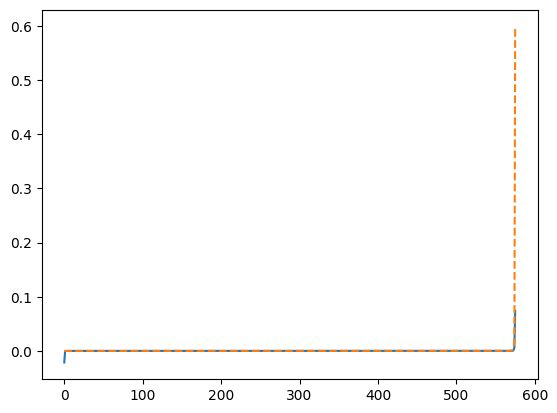

In [81]:
mf = kg.positive_matrix_functions
Zh = opt_result.point
print(opt_result.cost)

L, V = torch.linalg.eigh(mf.matrix_power_svd(A.double().as_mat() @ A.double() + C @ C.T, 1/2, double=True) - (A.double().as_mat() + Zh @ Zh.T))
L1, V1 = torch.linalg.eigh(mf.matrix_power_svd(A.double().as_mat() @ A.double() + C @ C.T, 1/2, double=True) - A.double().as_mat())

import matplotlib.pyplot as plt
plt.plot(L)
plt.plot(L1, '--')
#plt.plot(L2, '-.')

print( ((A.double().as_mat() @ A + C @ C.T - mf.mat_pow(A.double().as_mat() + Zh @ Zh.T, 2)) ** 2).sum() / 4 )

plt.show()

In [61]:
Zht = torch.Tensor(Zh).double()
Ad = A.double()
mf.matrices_norm(Ad.as_mat() @ Ad + (Ad @ Zht) @ Zht.T + Zht @ (Zht.T @ Ad) + Zht @ (Zht.T @ Zht) @ Zht.T - Ad.as_mat() @ Ad - C @ C.T , 'fro')**2 / 4

tensor(0.0006, dtype=torch.float64)

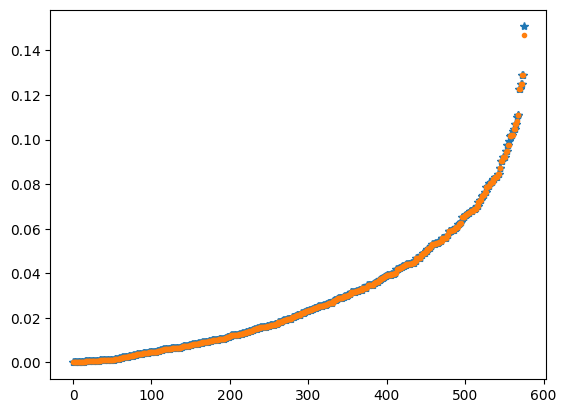

In [93]:
c = C.reshape([24,24]).double()
#Lc, Vc = torch.linalg.eigh(torch.kron(torch.eye(24, dtype=torch.double), c.T @ c) - C @ C.T/24)
#Lc, Vc = torch.linalg.eigh(torch.kron(c@c.T, torch.eye(24, dtype=torch.double)) - C @ C.T/24)
Lc2, Vc2 = torch.linalg.eigh(torch.kron(mf.matrix_power_svd(c@c.T, 1/2), mf.matrix_power_svd(c.T @ c, 1/2)) - C @ C.T/24)
Lc, Vc = torch.linalg.eigh(torch.kron(mf.matrix_power_svd(c@c.T, 1/2), mf.matrix_power_svd(c.T @ c, 1/2)))

plt.plot(Lc, '*')
plt.plot(Lc2, '.')
plt.show()

# Geoopt

In [51]:
import geoopt

In [234]:


## doesn't work
A = ricc.Kron([a.double(), b.double()])
#mm = geoopt.manifolds.SymmetricPositiveDefinite()
lr = 1e-1
#zz = torch.randn(n,n).tril()
#ZZ = geoopt.ManifoldTensor(zz@zz.T /n + torch.eye(n)*1e-6, manifold=mm, requires_grad=True)
#ZZ = (zz@zz.T /n + torch.eye(n)*1e-6).requires_grad_()
#def cost_noob(ZZ):
#    return ((ricc._symm2(A @ ZZ) + ZZ @ ZZ - C @ C.T) ** 2).sum() / n

#params = [ZZ]

#with torch.no_grad():
#    print(cost_noob(ZZ))

Y = torch.zeros_like(C)
Y += C
Y0 = torch.zeros_like(Y)
Y0 += Y
Y = Y.requires_grad_()
params = [Y]
def cost(Y):
    YtY = Y.T @ Y
    L = torch.cat([C, A @ Y, Y], -1)
    _, Lr = torch.linalg.qr(L, 'reduced')
    s = C.size()[-1]
    Lc = Lr[:, :s]
    L2 = Lr[:, s:s+k]
    Ly = Lr[:, s+k:]
    return ((-Lc @ Lc.T + ricc._symm2(L2 @ Ly.T) + Ly @ YtY @ Ly.T) ** 2).sum() / 4

opt = torch.optim.Adam(params, lr)
for i in range(20):
    err = cost(params[0])
    opt.zero_grad()
    err.backward(retain_graph=False)
    opt.step()

#mm = ricc.FixedRankPositiveDefinite()

In [243]:
from functools import partial
import geoopt
A = ricc.Kron([a.double(), b.double()]).cuda()
n = A._mat_size

k = 1
mm = ricc.PSDFixedRank(n, k)
print(mm)
lr = 1e1  # riemannian adam
#lr = 1e0  # adam
#lr = 1e-4

Y = torch.zeros_like(C)
Y += C
Y = Y.cuda()
Y0 = torch.zeros_like(Y).cuda()
Y0 += Y
Y = geoopt.ManifoldTensor(Y, manifold=mm, requires_grad=True)
#Y = (Y/torch.sqrt((Y**2).sum(0))).requires_grad_()

params = [Y]
def cost(Y):
    YtY = Y.T @ Y
    L = torch.cat([C.cuda(), A @ Y, Y], -1)
    _, Lr = torch.linalg.qr(L, 'reduced')
    s = C.size()[-1]
    Lc = Lr[:, :s]
    L2 = Lr[:, s:s+k]
    Ly = Lr[:, s+k:]
    return ((-Lc @ Lc.T + ricc._symm2(L2 @ Ly.T) + Ly @ YtY @ Ly.T) ** 2).sum() / 4

#opt = geoopt.optim.RiemannianLineSearch(params, )
opt = geoopt.optim.RiemannianAdam(params, lr)
#opt = torch.optim.Adam(params, lr)

import time
st = time.time()
for i in range(2000):
    if i<3:
        print('\b',i)
    err = cost(params[0])
    opt.zero_grad()
    err.backward()
    opt.step(partial(cost, params[0]))
print(time.time()-st)

Quotient manifold of 576x576 psd matrices of rank 1 manifold
 0
 1
 2
6.578739643096924


In [244]:
torch.abs(Y-Y0).sum()

tensor(19.7468, device='cuda:0', grad_fn=<SumBackward0>)

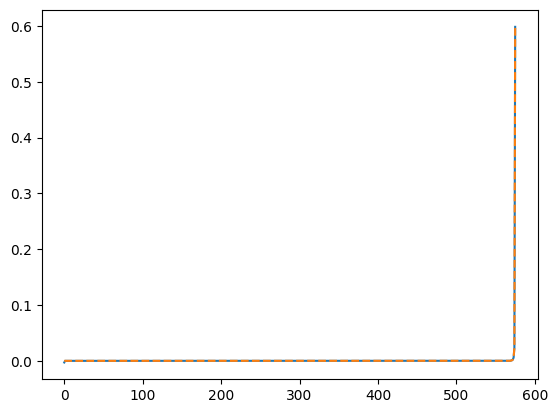

In [245]:
import matplotlib.pyplot as plt

Zh = params[0].detach().cpu()


L, V = torch.linalg.eigh(mf.matrix_power_svd(A.as_mat().cpu() @ A.as_mat().cpu() + C @ C.T, 1/2, double=True) - (A.as_mat().cpu() + Zh @ Zh.T))
L1, V1 = torch.linalg.eigh(mf.matrix_power_svd(A.as_mat().cpu() @ A.as_mat().cpu() + C @ C.T, 1/2, double=True) - A.as_mat().cpu())

import matplotlib.pyplot as plt
plt.plot(L)
plt.plot(L1, '--')
plt.show()

# homemade LRCF Newton

In [96]:
import pymor
import pymor.algorithms.lradi
A = ricc.Kron_pymor([a, b])
E = pymor.operators.constructions.IdentityOperator(A.source)
B = A.source.from_numpy(C.T)
so = {'large_ritz_num': 1,
      'small_ritz_num': 1,
      'tol': 1e0,
}
print(so)
p = pymor.algorithms.lradi.wachspress_shifts_init(A, E, B, so)
print(p)

{'large_ritz_num': 1, 'small_ritz_num': 1, 'tol': 1.0}
[-1.02551628e+01 -1.78754080e-02 -3.11390073e-05]


In [116]:
A = ricc.Kron([a, b])

max_line_iter = 50
cost_old = cost(Yo)
Yn = C.cpu().numpy()
Yo = np.zeros_like(Yn)
s = C.shape[-1]
step_size = 1
armijo = False
it_ = 0
while (not armijo) and it_ < max_line_iter:
    it_ += 1
    step_size /= 2
    Z = Yo + step_size * Yn
    cost_new = cost(Z)
    armijo = cost_old - cost_new > 0
    if armijo and (it_ == 1):  # maybe understep, reset and try again
        print('ay')
        armijo = 0
        it_ = 0
        step_size *= 4  # will get divided by 2 before next application
        

st = time.time()
Z = ricc.lrcf_nm(A.double(), C.double(), rank=k, Z0=torch.Tensor(Z).double())
print(time.time()-st)

cost(Z.numpy())

04:16:35 gram_schmidt: Orthonormalizing vector 2 again
04:16:35 gram_schmidt: Orthonormalizing vector 3 again
04:16:35 gram_schmidt: Orthonormalizing vector 4 again
04:16:35 gram_schmidt: Orthonormalizing vector 5 again
04:16:35 gram_schmidt: Orthonormalizing vector 2 again
04:16:35 gram_schmidt: Orthonormalizing vector 3 again
04:16:35 gram_schmidt: Orthonormalizing vector 4 again
04:16:35 gram_schmidt: Orthonormalizing vector 5 again


0.037500858306884766


array(2.58322399e+27)

tensor(592.9480, dtype=torch.float64) tensor(-493.4468, dtype=torch.float64)


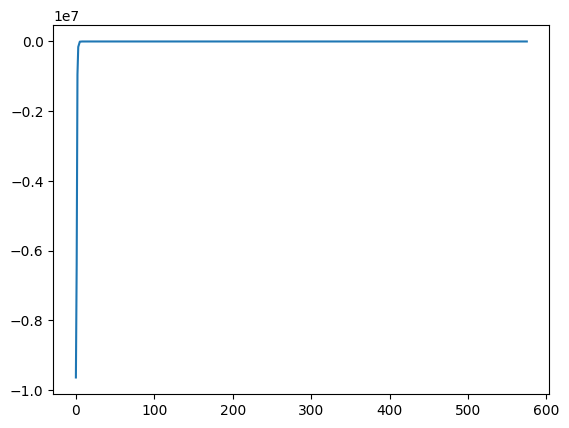

In [114]:
import matplotlib.pyplot as plt

Zh = Z

print(Zh.max(), Zh.min())

L, V = torch.linalg.eigh(mf.matrix_power_svd(A.double().as_mat() @ A.double().as_mat() + C @ C.T, 1/2, double=True) - (A.as_mat() + Zh @ Zh.T))
#L, V = torch.linalg.eigh(mf.matrix_power_svd(A.as_mat() @ A.as_mat() + C @ C.T, 1/2, double=True) - A.as_mat())

plt.plot(L)
plt.show()

## chebyshev fun, for rational krylov to approximate M^(1/p)

In [439]:
x = np.arange(1, 101)/100
x_fit = np.logspace(-4, 0, 100)
fun = lambda x: np.sign(x) * (np.abs(x)) ** (1/3)
cheb_poly = np.polynomial.chebyshev.Chebyshev.fit(x_fit, fun(x_fit), 10, domain=[x_fit.min(), x_fit.max()])
#cheb_poly = np.polynomial.chebyshev.Chebyshev.interpolate(fun, 10, domain=[x_fit.min(), x_fit.max()])


In [441]:
cheb_poly.roots()

array([-0.00521518+0.j        ,  0.06607112-0.1137467j ,
        0.06607112+0.1137467j ,  0.32034326-0.20964723j,
        0.32034326+0.20964723j,  0.64507391-0.21826561j,
        0.64507391+0.21826561j,  0.91747604-0.12990738j,
        0.91747604+0.12990738j,  1.03651672+0.j        ])

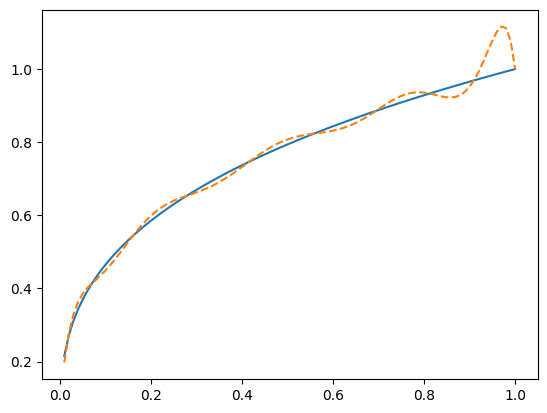

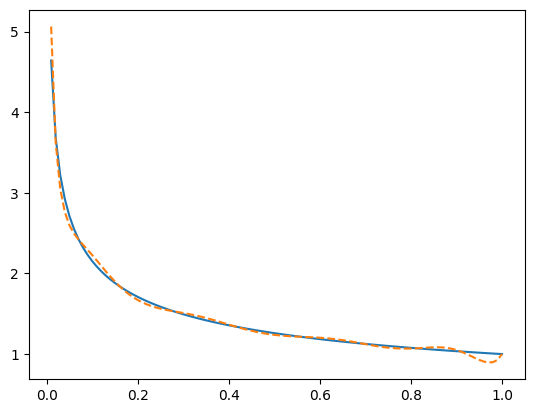

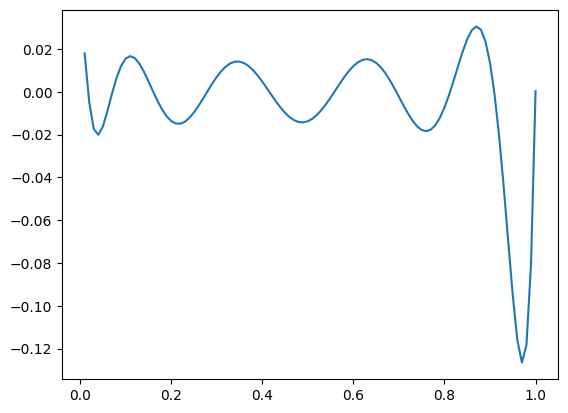

In [172]:

plt.plot(x, fun(x))
plt.plot(x, cheb_poly(x), '--')

plt.figure()

plt.plot(x, 1/fun(x))
plt.plot(x, 1/cheb_poly(x), '--')

plt.figure()

plt.plot(x, fun(x)-cheb_poly(x))


plt.show()